The objective of this guided example is to build an encoder-decoder U-Net architecture to segment an input image. Semantic segmentation use cases used in autonomous vehicle , ultrasound medical imaging, satellite image analysis, image search engines and for robotic navigation

#Import Libraries

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# PyTorch is a Python package that provides two high-level features:
# Tensor computation with strong GPU acceleration and Deep neural networks built
import torch
from torch import nn
import torch.nn as nn
import os

#PyTorch provides two data primitives: torch.utils.data.
#DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data.
from torch.utils.data import Subset
from os import path

#torchvision package consists of popular datasets, model architectures,
#and common image transformations for computer vision
import torchvision
import torchvision.transforms as T #Transforms are common image transformations.
from typing import Sequence

#Functional transforms give fine-grained control over the transformations.
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

#TorchMetrics is a collection of 100+ PyTorch metrics implementations
#and an easy-to-use API to create custom metrics
import torchmetrics as TM


# Data loading

The Oxford-IIIT Pet Dataset is a 37 category pet dataset with roughly 200 images for each class created by the Visual Geometry Group at Oxford.

In [4]:
project_dir = '/content/drive/MyDrive/GenAIBOOK/unet'
pets_path_train = os.path.join(project_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(project_dir, 'OxfordPets', 'test')

#Data Transform

In [5]:
# Transformation (Random horizaontal flip & Image Resize is applied on both Target and label i.e segmentation mask images

class ImageAug(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        transform=T.ToTensor(),
        target_transform=T.ToTensor(),
        transform_target_aug=None,
        Image_transformation=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=transform,
            target_transform=target_transform,
        )
        self.transform_target_aug = transform_target_aug
        self.Image_transformation = Image_transformation

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        if self.Image_transformation is not None:
            both = torch.cat([input, target], dim=0)
            both = self.Image_transformation(both)
            (input, target) = torch.split(both, 3, dim=0)

        if self.transform_target_aug is not None:
            target = self.transform_target_aug(target)

        return (input, target)

In [6]:
# Create a tensor for a segmentation trimap.

def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(

    Image_transformation=T.Compose([
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.6),
    ]),
    transform_target_aug=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)



# Train & Test Loaders



In [7]:
# Creation of dataloader (train & test instance of pets dataset after applying randon augmention)
# Neares neighbour algorithm is used for reizing (128 x 128)

train_pets = ImageAug(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)
test_pets = ImageAug(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

train_pets_loader = torch.utils.data.DataLoader(
    train_pets,
    batch_size=64,
    shuffle=True,
)
test_pets_loader = torch.utils.data.DataLoader(
    test_pets,
    batch_size=64,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(train_pets_loader))
(test_pets_inputs, test_pets_targets) = next(iter(test_pets_loader))
train_pets_inputs.shape, train_pets_targets.shape


100%|██████████| 791918971/791918971 [00:38<00:00, 20335604.15it/s]


Extracting /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/train/oxford-iiit-pet/images.tar.gz to /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 9870540.03it/s] 


Extracting /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:39<00:00, 20101506.83it/s]


Extracting /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/test/oxford-iiit-pet/images.tar.gz to /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 9956055.40it/s] 


Extracting /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to /content/drive/MyDrive/GenAIBOOK/unet/OxfordPets/test/oxford-iiit-pet


(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

In [30]:
print(len(train_pets))
print(len(train_pets_loader.dataset))
print(len(train_pets_targets))

print(len(test_pets))
print(len(test_pets_loader.dataset))
print(len(test_pets_targets))

3680
3680
64
3669
3669
64


#Visualization

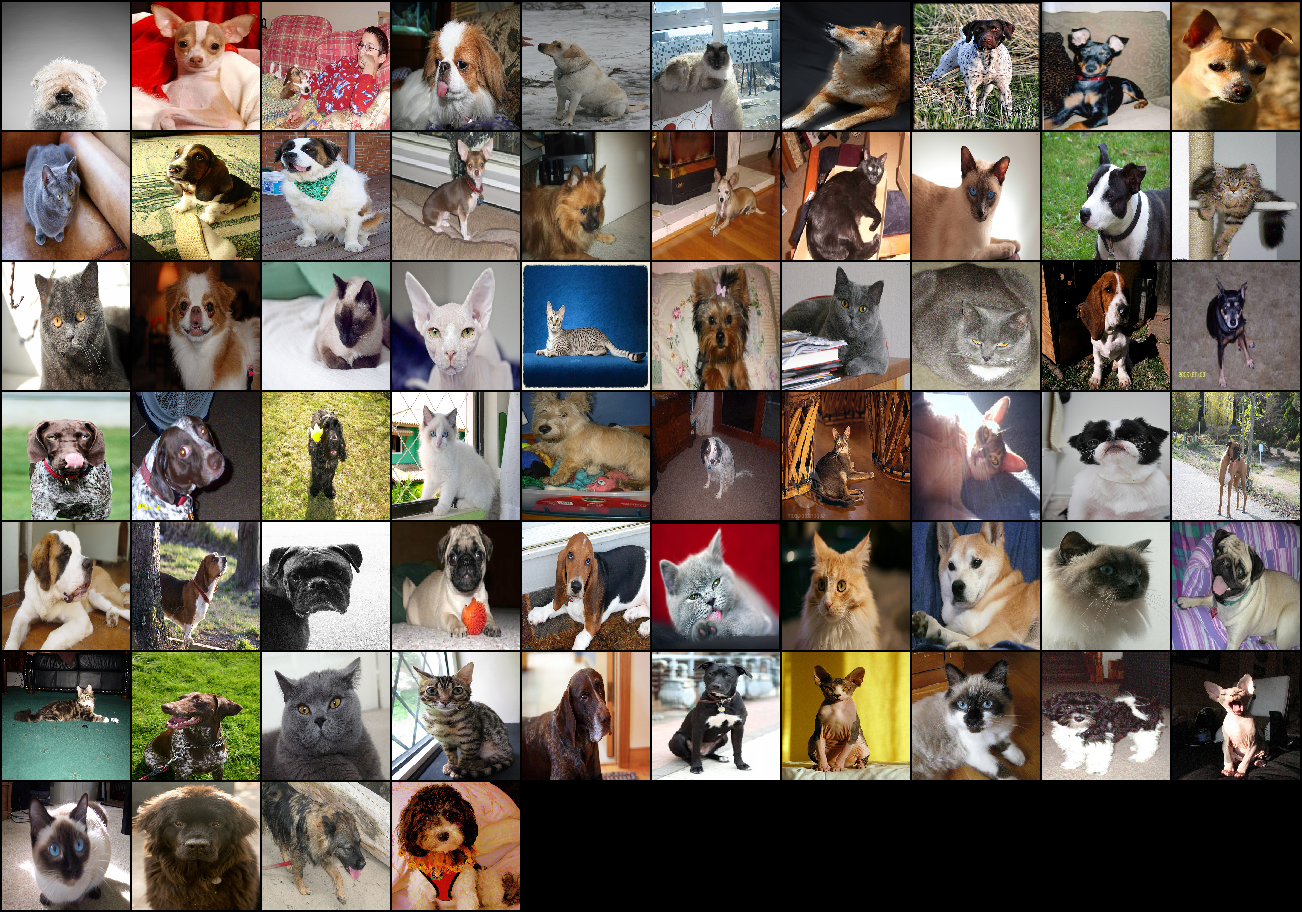

In [12]:
# Visualize Input image
input = torchvision.utils.make_grid(train_pets_inputs, nrow=10)
T.ToPILImage()(input)

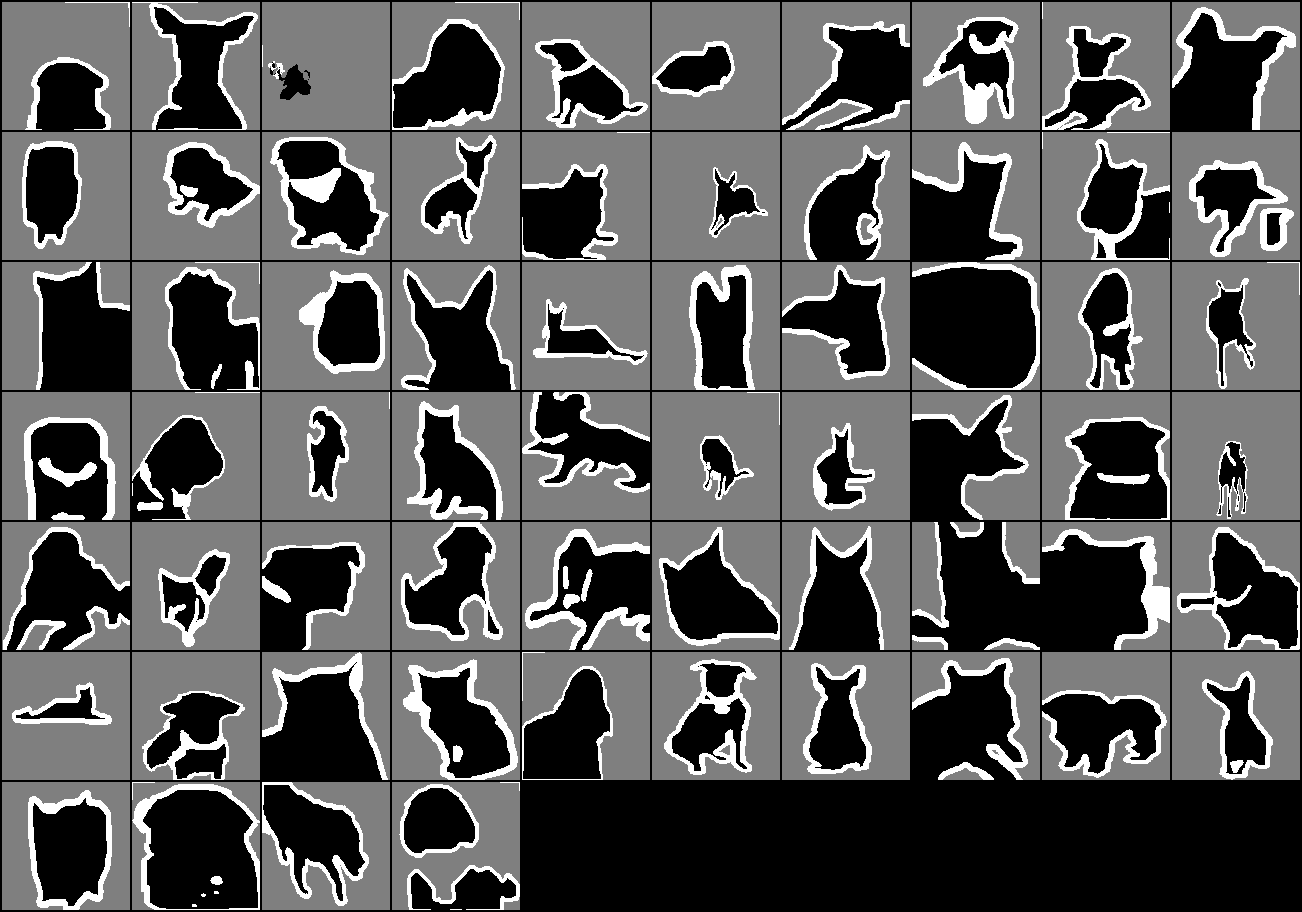

In [14]:
#Visualize the target
target = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=10) # Normalize the mask value to (0,1,2) by dividing with 2.0
T.ToPILImage()(target)

#Model Build

In [9]:
def d_conv(in_channels, out_channels):
    # The convolution operations - output result size to be same as input size.
    conv_operation = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_operation

In [10]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()
        self.mx_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.d_conv1 = d_conv(3, 64)
        self.d_conv2 = d_conv(64, 128)
        self.d_conv3 = d_conv(128, 256)
        self.d_conv4 = d_conv(256, 512)
        self.d_conv5 = d_conv(512, 1024)
        # Expanding path.
        self.u_trans1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.u_conv1 = d_conv(1024, 512)
        self.u_trans2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.u_conv2 = d_conv(512, 256)
        self.u_trans3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.u_conv3 = d_conv(256, 128)
        self.u_trans4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.u_conv4 = d_conv(128, 64)
        # no of classes as per out channels
        self.out = nn.Conv2d(
            in_channels=64, out_channels=n_class,
            kernel_size=1
        )
    def forward(self, x):
        d1 = self.d_conv1(x)
        d2 = self.mx_pool(d1)
        d3 = self.d_conv2(d2)
        d4 = self.mx_pool(d3)
        d5 = self.d_conv3(d4)
        d6 = self.mx_pool(d5)
        d7 = self.d_conv4(d6)
        d8 = self.mx_pool(d7)
        d9 = self.d_conv5(d8)
        # Not applying max pooling to d9

        u1 = self.u_trans1(d9)
        x = self.u_conv1(torch.cat([d7, u1], 1))
        u2 = self.u_trans2(x)
        x = self.u_conv2(torch.cat([d5, u2], 1))
        u3 = self.u_trans3(x)
        x = self.u_conv3(torch.cat([d3, u3], 1))
        u4 = self.u_trans4(x)
        x = self.u_conv4(torch.cat([d1, u4], 1))
        out = self.out(x)
        return out

#Train Model

In [11]:
# Training loop. Train the model for multiple epochs.

def train_model_u(model, loader, epochs, optimizer, scheduler):
    #test_inputs, test_targets = test_data
    for epoch in range(epochs):
        print(f"Epoch: {epoch:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        model.train().cuda()
        criteria = nn.CrossEntropyLoss(reduction='mean')
        r_loss = 0.0
        r_samples = 0

        for batch_no, (inputs, targets) in enumerate(loader, 0):

            optimizer.zero_grad()
            inputs = inputs.cuda()
            targets = targets.cuda()
            outputs = model(inputs)
            targets = targets.squeeze(dim=1) # Squeeze NCHW -> NHW (channels)
            outputs= outputs.squeeze(dim=1)
            loss = criteria(outputs, targets)
            loss.backward()
            optimizer.step()
            r_samples += targets.size(0)
            r_loss += loss.item()
            print("Trained {} samples, Loss: {:.4f}".format( r_samples,r_loss / (batch_no+1)))

        #with torch.inference_mode():
        # Display the plt in the final training epoch.
          #view_output(model, test_inputs, test_targets, epoch=epoch)
        #scheduler.step()
        #print("")


In [12]:
# Hyper Parameters - Optimizer & Learning Rate Scheduler.
model = UNet(n_class=200)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)

In [ ]:
# Train the model
epochs=10
train_model_u(model, train_pets_loader, epochs, optimizer, scheduler)

In [25]:
len(test_pets)

3669

In [19]:

def view_output(model, test_pets_targets, test_pets_labels):
    torch.no_grad()
    model.eval().cuda()
    predictions = model(test_pets_targets.cuda())
    test_pets_labels = (test_pets_labels.cuda())
    print("Predictions Shape: {}".format(predictions.shape))
    prediction_labels = predictions.argmax(dim=1)
    prediction_labels = prediction_labels.unsqueeze(1)
    prediction_mask = prediction_labels.to(torch.float)

    pix_metric = (TM.classification.MulticlassAccuracy(3, average='micro')).cuda()
    pix_acc = pix_metric(prediction_labels, test_pets_labels)
    plt_title = f'Accuracy[Pixel: {pix_acc:.4f}]'
    print(plt_title)

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(plt_title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(T.ToPILImage()(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(T.ToPILImage()(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground_Truth")

    fig.add_subplot(3, 1, 3)
    plt.imshow(T.ToPILImage()(torchvision.utils.make_grid(prediction_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")


    plt.show()


Predictions Shape: torch.Size([64, 200, 128, 128])
Accuracy[Pixel: 0.8574]


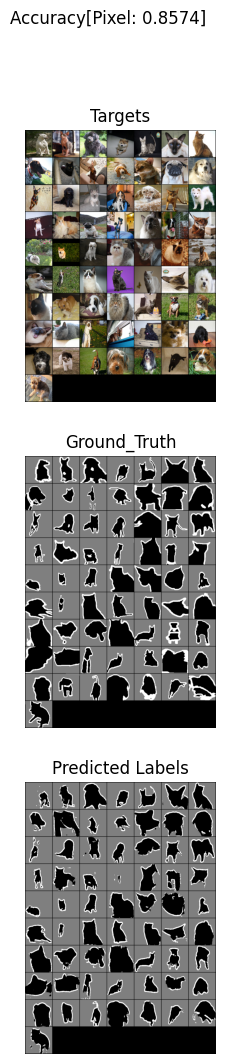

In [20]:
view_output(model, test_pets_inputs, test_pets_targets)

In [ ]:
# Save the model
checkpoint=f"unet_pets_CELoss.pth"
torch.save(m.state_dict(), os.path.join(project_dir, checkpoint))